With the importance placed on getting a college degree nowadays ([65 percent of workers have at least some postsecondary education](https://cew.georgetown.edu/cew-reports/americas-divided-recovery/)), students more than ever need to focus on getting into colleges that will best help them achieve their goals. Sites like (US News)[https://www.usnews.com/best-colleges] have become the de-facto standard for students trying to search through hundreds of universities and deciding which is the best fit. Specifically, US News' ranking system is given enormous weight, influencing (how schools are perceived by the general public)[https://www.forbes.com/sites/robertzafft/2021/12/07/us-news-business-school-rankings-crucial-but-meaningless/].



## Part 1: Web Scraping
After spending 8 hours or so writing a web scraper to get all the components from the website, it turns out that each page provides JSON objects that contain all the data in a much easier to extract format.

In [132]:
from bs4 import BeautifulSoup

html_doc = open("2022 Best National Universities US News Rankings.htm", encoding="utf8")
soup = BeautifulSoup(html_doc, 'html.parser')

In [133]:
anchors = soup.select('a[class*="card-name"]')
links = list(map(lambda x: x.get('href'), anchors))
print(links[:10])
print(len(links))

['https://www.usnews.com/best-colleges/princeton-university-2627', 'https://www.usnews.com/best-colleges/columbia-university-2707', 'https://www.usnews.com/best-colleges/harvard-university-2155', 'https://www.usnews.com/best-colleges/massachusetts-institute-of-technology-2178', 'https://www.usnews.com/best-colleges/yale-university-1426', 'https://www.usnews.com/best-colleges/stanford-university-1305', 'https://www.usnews.com/best-colleges/university-of-chicago-1774', 'https://www.usnews.com/best-colleges/university-of-pennsylvania-3378', 'https://www.usnews.com/best-colleges/california-institute-of-technology-1131', 'https://www.usnews.com/best-colleges/duke-university-2920']
392


In [65]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import json

link = "https://www.usnews.com/best-colleges/princeton-university-2627"

def get_soup_obj(link, subpage):
    url = link + "/" + subpage
    agent = {"User-Agent":'Mozilla/5.0'}
    response = requests.get(url, headers = agent)
    return BeautifulSoup(response.text, 'html.parser')

soup = get_soup_obj(link, "student-life")

Then, we look at the structure of the HTML files and find the line in the script containing the JSON object, and extract it:

In [140]:
def get_json_from_soup(soup_obj):
    script_json_line = soup_obj.find_all("script")[-2].contents[0].split("\n")[4]
    json_obj_str = script_json_line[script_json_line.find("{"):-1].replace("undefined","null")
    json_obj = json.loads(json_obj_str)
        
    base_key = 'src/containers/pages/education/higher-education/colleges/profile'
    json_data = json_obj.get(f'{base_key}/overview.js',False) or \
                json_obj.get(f'{base_key}/generic.js',False) or \
                json_obj.get(f'{base_key}/rankings.js',None)
    
    #print("json_data: " + str(json_data)[:20])
    json_data = json_data['data']['context']['data']['page']
    return json_data
    #return {'schoolData': json_data['schoolData'], 
    #        'fields': json_data['fields'],
    #        'schoolDetails': json_data['schoolDetails']}

#print(get_json_from_soup(get_soup_obj(link,"")))

The 'fields' data indicates how the data is structured, the 'schoolData' field provides the values, and 'schoolDetails' provides basic info not in 'schoolData'.

We can use these methods to get all the data from every university and put it in a single JSON object, with the university name as the key.

In [ ]:
all_univ_json_data = {}
pages = ["", "overall-rankings", "applying", "academics", "student-life", "paying", "campus-info"]
for link in links:
    json_out = {'fields': {}, 'data': {}}
    for page in pages:
        json_data_fields = get_json_from_soup(get_soup_obj(link,page))
        #print(page + "::" + str(json_data_fields)[:20])
        json_out['data'].update(json_data_fields['schoolData'])
        json_out['fields'].update(json_data_fields['fields'])
    json_out['details'] = get_json_from_soup(get_soup_obj(link,""))['schoolDetails']
    name = json_out['details']['displayName']
    all_univ_json_data[name] = json_out
    print(name)

In [155]:
with open('all_univ.json', 'w') as outfile:
    json.dump(all_univ_json_data, outfile)

### Part 1.2: Data Compression

In [5]:
import json

# Read in the university data
with open('all_univ.json', 'r') as infile:
    all_univ_json_data = json.load(infile)

There are a lot of unnecessary fields in this data that we can remove, to make our analysis life a lot easier.

In [ ]:
nested_fields = set()

def create_field_label_keys():
    # Assumes that all of the possible data attributes are contained within the first university on the list
    key = {}
    # Iterate through fields, putting the labels and fieldNames into a dictionary for future reference
    for field in all_univ_json_data['Princeton University']['fields'].values():
        if 'fieldName' in field:
            key[field['fieldName']] = field['label']
    return key    
    
def get_data_value(univ, field_name):
    return univ['data'][field_name]['rawValue'] if 'rawValue' in univ['data'][field_name] else None
    #print(f"\t\t{subfield_label} ({field_data['fieldName']}): {subfield_data['rawValue']}")

def get_field_value(univ, field):
    if 'subFields' in field:
        subfields = {}
        for subfield in field['subFields']:
            subfield_fields = subfield['fields'] if "fields" in subfield else [subfield['field']] 
            for subfield_field in subfield_fields:
                nested_fields.add(subfield_field)
                subfields[subfield_field] = get_data_value(univ, subfield_field)
        return subfields
    else:
        if field['fieldName'] not in nested_fields:
            return get_data_value(univ, field['fieldName'])

# Returns a tuple; the first value is the actual data, the second is the additional part of the key mapping
def get_details_info(univ):
    univ_details = univ['details'].copy()
    univ_details.pop("mainRank")
    univ_details.pop("crossWalk")
    keys = {}
    ranks = {}
    for rank_name, rank_data in univ_details['ranks'].items():
        if rank_data['isPublic'] and not rank_data['locked']:
            keys[rank_name] = rank_data['displayName']
            ranks[rank_name] = rank_data['displayRank'][1:]
    univ_details['ranks'] = ranks
    return (univ_details, keys)

univ_keys = create_field_label_keys() # map between field keys and readable labels

all_univ_data = {}
for name, univ in list(all_univ_json_data.items()):
    univ_data = {}
    for field in univ['fields'].values():
        #print(f"{field['label']}: {field['isPublic']}")
        if field['isPublic']: 
            univ_data[field['fieldName']] = get_field_value(univ, field)
    # Add info from 'details'
    details_data, details_keys = get_details_info(univ)
    univ_keys.update(details_keys)
    univ_data.update(details_data)
    all_univ_data[name] = univ_data
    print(name)

In [13]:
with open('all_univ_compressed.json', 'w') as outfile:
    json.dump(all_univ_data, outfile)
with open('all_univ_compressed_key.json', 'w') as outfile:
    json.dump(univ_keys, outfile)

For some reason, there are certain values (like the average salary of recent graduates) which are visible on the website but aren't in the data set; I'll just live with that for now.

## Part 2: Analysis

(Explain how US News ranking works)

First, let's ask a rather obvious question: does the ranking done by US News correlate with other metrics of success, like starting salary? Because, as previously mentioned, this scraper doesn't by itself get the data about average salary, I need to supplement this with another web scraper I wrote which directly reads from the webpage (link). 

In [53]:
#!pip install ijson
#import ijson
import pandas as pd, numpy as np
import seaborn as sns

In [24]:
with open('all_univ_compressed.json', 'r') as infile:
    all_univ_data = json.load(infile)

In [62]:
salaries = pd.read_csv("all_univ_rows.csv")["Median starting salary of alumni "].apply( 
          lambda x: x if pd.isna(x) else int(x[1:].replace(",","")))

display_score = []
for (name, data), salary in zip(all_univ_data.items(),salaries):
    display_score.append({"name": name, 
                          "score": np.nan if isinstance(data["vDisplayScore"],str) else data["vDisplayScore"], 
                          "medianSalary":salary})

# filter out unusable rows (score or medianSalary is not a number)
score_df = pd.DataFrame(display_score)
score_df.dropna()

,name,score,medianSalary
0,Princeton University,100.0,71300.0
1,Columbia University,97.0,67800.0
2,Harvard University,97.0,69000.0
3,Massachusetts Institute of Technology,97.0,82700.0
4,Yale University,96.0,65900.0
...,...,...,...
293,Portland State University,42.0,49300.0
294,South Dakota State University,42.0,50300.0
295,University of Hawaii at Hilo,42.0,44600.0
296,University of Puerto Rico--Rio Piedras,42.0,41800.0


[Text(0.5, 1.0, 'University Scores Vs. Median Alumni Starting Salary'),
 Text(0.5, 0, 'US News Score (0-100)'),
 Text(0, 0.5, 'Median Salary of Recent Alumni (USD)')]

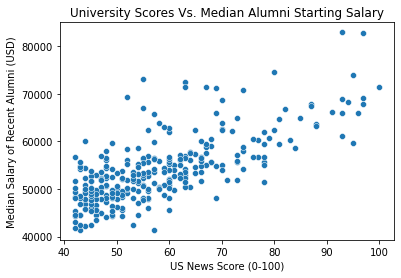

In [69]:
ax = sns.scatterplot(data=score_df, x="score", y="medianSalary")
ax.set(title="University Scores Vs. Median Alumni Starting Salary",xlabel="US News Score (0-100)",ylabel="Median Salary of Recent Alumni (USD)")

We can see a decent positive correlation, as we'd expect; however, we had to remove the bottom values from the graph because US News doesn't give a specific number for any university in the bottom 25 percent, which ends up being universities with a score under 42. 

In [ ]:
TODO Quantify correlation

### 2.2 Predicting Rankings

Unfortunately, unless you pay for premium access, you are only able to see a small portion of the factors that go into the ranking. But that leads one to ask: how much do those factors matter? Is the correlation between the different factors strong enough that we can predict the rankings using only the factors that we can access for free?